# Cryptocurrency

https://blog.patricktriest.com/analyzing-cryptocurrencies-python/

## Step 1 - Import the Dependencies At The Top of The Notebook

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime, timedelta, date
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

py.init_notebook_mode(connected=True)

In [2]:
#Parameter:
import os
from pathlib import Path

filename = 'BCHARTS-KRAKENUSD.pkl'
load_date = datetime.fromtimestamp(Path(filename).stat().st_mtime)
if load_date.date() == date.today():
    load_from_cache = True
else:
    load_from_cache = False
    
print(load_from_cache)

False


In [3]:
load_from_cache = True

## Step 2 - Retrieve Bitcoin Pricing Data

### Step 2.1 - Define Quandl Helper Function

In [4]:
def get_quandl_data(quandl_id, cache = True):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    if cache == True:
        try:
            f = open(cache_path, 'rb')
            df = pickle.load(f)   
            print('Loaded {} from cache'.format(quandl_id))
        except (OSError, IOError) as e:
            print('Downloading {} from Quandl'.format(quandl_id))
            df = quandl.get(quandl_id, returns="pandas")
            df.to_pickle(cache_path)
            print('Cached {} at {}'.format(quandl_id, cache_path))
    else:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

### Step 2.2 - Pull Kraken Exchange Pricing Data

In [5]:
# Pull Kraken BTC price exchange data
btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD', cache = load_from_cache)
btc_usd_price_kraken.tail()

Loaded BCHARTS/KRAKENUSD from cache


Open    High     Low   Close  Volume (BTC)  Volume (Currency)  \
Date                                                                          
2019-11-07  9339.6  9375.0  9084.9  9205.0   2735.367619       2.520131e+07   
2019-11-08  9205.0  9247.6  8675.0  8766.0   6097.430965       5.418233e+07   
2019-11-09  8765.9  8877.2  8721.0  8812.0   1669.902481       1.469258e+07   
2019-11-10  8812.1  9147.6  8751.7  9039.1   2916.522947       2.608645e+07   
2019-11-11  9039.0  9041.4  9039.0  9041.4      2.385548       2.156348e+04   

            Weighted Price  
Date                        
2019-11-07     9213.133251  
2019-11-08     8886.091685  
2019-11-09     8798.464444  
2019-11-10     8944.368101  
2019-11-11     9039.212102

In [6]:
# Chart the BTC pricing data
btc_trace = go.Scatter(x=btc_usd_price_kraken.index, y=btc_usd_price_kraken['Weighted Price'])
py.iplot([btc_trace])

### Step 2.3 - Pull Pricing Data From More BTC Exchanges

In [7]:
# Pull pricing data for 3 more BTC exchanges
exchanges = [#'COINBASE',
             'BITSTAMP'#,
             #'ITBIT'
]

exchange_data = {}

exchange_data['KRAKEN'] = btc_usd_price_kraken

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code, cache = load_from_cache)
    exchange_data[exchange] = btc_exchange_df

Loaded BCHARTS/BITSTAMPUSD from cache


### Step 2.4 - Merge All Of The Pricing Data Into A Single Dataframe

In [8]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

# Merge the BTC price dataseries' into a single dataframe
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')
btc_usd_datasets.tail()

KRAKEN     BITSTAMP
Date                                
2019-11-07  9213.133251  9218.669877
2019-11-08  8886.091685  8904.225442
2019-11-09  8798.464444  8809.840042
2019-11-10  8944.368101  8974.223982
2019-11-11  9039.212102  9042.095429

### Step 2.5 - Visualize The Pricing Datasets

In [9]:
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = True
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)
    
# Plot all of the BTC exchange prices
df_scatter(btc_usd_datasets, 'Bitcoin Price (USD) By Exchange')

### Step 2.6 - Clean and Aggregate the Pricing Data

In [10]:
# Remove "0" values
btc_usd_datasets.replace(0, np.nan, inplace=True)
# Plot the revised dataframe
df_scatter(btc_usd_datasets, 'Bitcoin Price (USD) By Exchange')

In [11]:
# Calculate the average BTC price as a new column
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)
# Plot the average BTC price
btc_trace = go.Scatter(x=btc_usd_datasets.index, y=btc_usd_datasets['avg_btc_price_usd'])
py.iplot([btc_trace])

## Step 3 - Retrieve Altcoin Pricing Data

### Step 3.1 - Define Poloniex API Helper Functions

In [12]:
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
pediod = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), pediod)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

### Step 3.2 - Download Trading Data From Poloniex

In [13]:
altcoins = ['ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=1420066800.0&end=1573715690.48578&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_LTC&start=1420066800.0&end=1573715690.48578&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XRP&start=1420066800.0&end=1573715690.48578&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETC&start=1420066800.0&end=1573715690.48578&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_STR&start=1420066800.0&end=1573715690.48578&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_DASH&start=1420066800.0&end=1573715690.48578&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_SC&start=1420066800.0&end=1573715690.48578&period=86400 fro

In [14]:
altcoin_data['ETH'].tail()

high       low      open     close      volume   quoteVolume  \
date                                                                           
2019-10-24  0.021840  0.021375  0.021754  0.021624  263.827324  12172.809162   
2019-10-25  0.021945  0.020763  0.021630  0.020965  323.595122  15123.501633   
2019-10-26  0.021038  0.018868  0.020950  0.019446  683.430994  35058.129883   
2019-10-27  0.019602  0.019106  0.019464  0.019295  205.364853  10609.619694   
2019-10-28  0.019460  0.018977  0.019274  0.019399   80.707050   4194.053180   

            weightedAverage  
date                         
2019-10-24         0.021673  
2019-10-25         0.021397  
2019-10-26         0.019494  
2019-10-27         0.019356  
2019-10-28         0.019243

### Step 3.3 - Convert Prices to USD

In [15]:
# Calculate USD Price as a new column in each altcoin dataframe
for altcoin in altcoin_data.keys():
    altcoin_data[altcoin]['price_usd'] =  altcoin_data[altcoin]['weightedAverage'] * btc_usd_datasets['avg_btc_price_usd']
    
# Merge USD price of each altcoin into single dataframe 
combined_df = merge_dfs_on_column(list(altcoin_data.values()), list(altcoin_data.keys()), 'price_usd')

# Add BTC price to the dataframe
combined_df['BTC'] = btc_usd_datasets['avg_btc_price_usd']

# Chart all of the altocoin prices
df_scatter(combined_df, 'Cryptocurrency Prices (USD)', seperate_y_axis=False, y_axis_label='Coin Value (USD)', scale='log')

## Step 4 - Correlation analysis

In [16]:
# Calculate the pearson correlation coefficients for cryptocurrencies in 2016
combined_df_2016 = combined_df[combined_df.index.year == 2016]
combined_df_2016.pct_change().corr(method='pearson')

ETH       LTC       XRP       ETC       STR      DASH        SC  \
ETH   1.000000 -0.057405  0.087995 -0.180951  0.038837  0.124465  0.168345   
LTC  -0.057405  1.000000  0.063289 -0.134475  0.124327 -0.002598  0.011237   
XRP   0.087995  0.063289  1.000000 -0.055493  0.324295  0.092328  0.020086   
ETC  -0.180951 -0.134475 -0.055493  1.000000 -0.103384 -0.001045 -0.009292   
STR   0.038837  0.124327  0.324295 -0.103384  1.000000  0.064254  0.142769   
DASH  0.124465 -0.002598  0.092328 -0.001045  0.064254  1.000000  0.024682   
SC    0.168345  0.011237  0.020086 -0.009292  0.142769  0.024682  1.000000   
XMR   0.090507  0.139085  0.033056 -0.103672  0.033683  0.126901  0.048264   
XEM   0.045951  0.167943  0.105826 -0.081281  0.228720  0.019492  0.106195   
BTC   0.002103  0.756675  0.057021 -0.169784  0.093268 -0.000552  0.033859   

           XMR       XEM       BTC  
ETH   0.090507  0.045951  0.002103  
LTC   0.139085  0.167943  0.756675  
XRP   0.033056  0.105826  0.057021  
ETC  -0.103672 -0.081281 -0.169784  
STR   0.033683  0.228720  0.093268  
DASH  0.126901  0.019492 -0.000552  
SC    0.048264  0.106195  0.033859  
XMR   1.000000  0.020735  0.139546  
XEM   0.020735  1.000000  0.234964  
BTC   0.139546  0.234964  1.000000

In [17]:
def correlation_heatmap(df, title, absolute_bounds=True):
    '''Plot a correlation heatmap for the entire dataframe'''
    heatmap = go.Heatmap(
        z=df.corr(method='pearson').as_matrix(),
        x=df.columns,
        y=df.columns,
        colorbar=dict(title='Pearson Coefficient'),
    )
    
    layout = go.Layout(title=title)
    
    if absolute_bounds:
        heatmap['zmax'] = 1.0
        heatmap['zmin'] = -1.0
        
    fig = go.Figure(data=[heatmap], layout=layout)
    py.iplot(fig)
    
correlation_heatmap(combined_df_2016.pct_change(), "Cryptocurrency Correlations in 2016")

C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



## Autocorrealtion Analysis

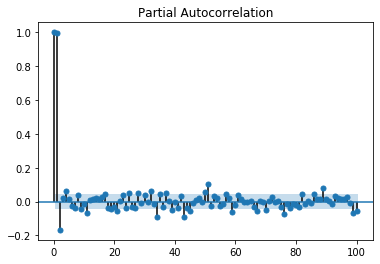

In [18]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(combined_df['BTC'].dropna(),lags = 100)
pyplot.show()
#combined_df['BTC']

DatetimeIndex(['2014-12-31 23:00:00', '2015-01-01 00:00:00',
               '2015-01-02 00:00:00', '2015-01-03 00:00:00',
               '2015-01-04 00:00:00', '2015-01-05 00:00:00',
               '2015-01-06 00:00:00', '2015-01-07 00:00:00',
               '2015-01-08 00:00:00', '2015-01-09 00:00:00'],
              dtype='datetime64[ns]', name='date', freq=None)


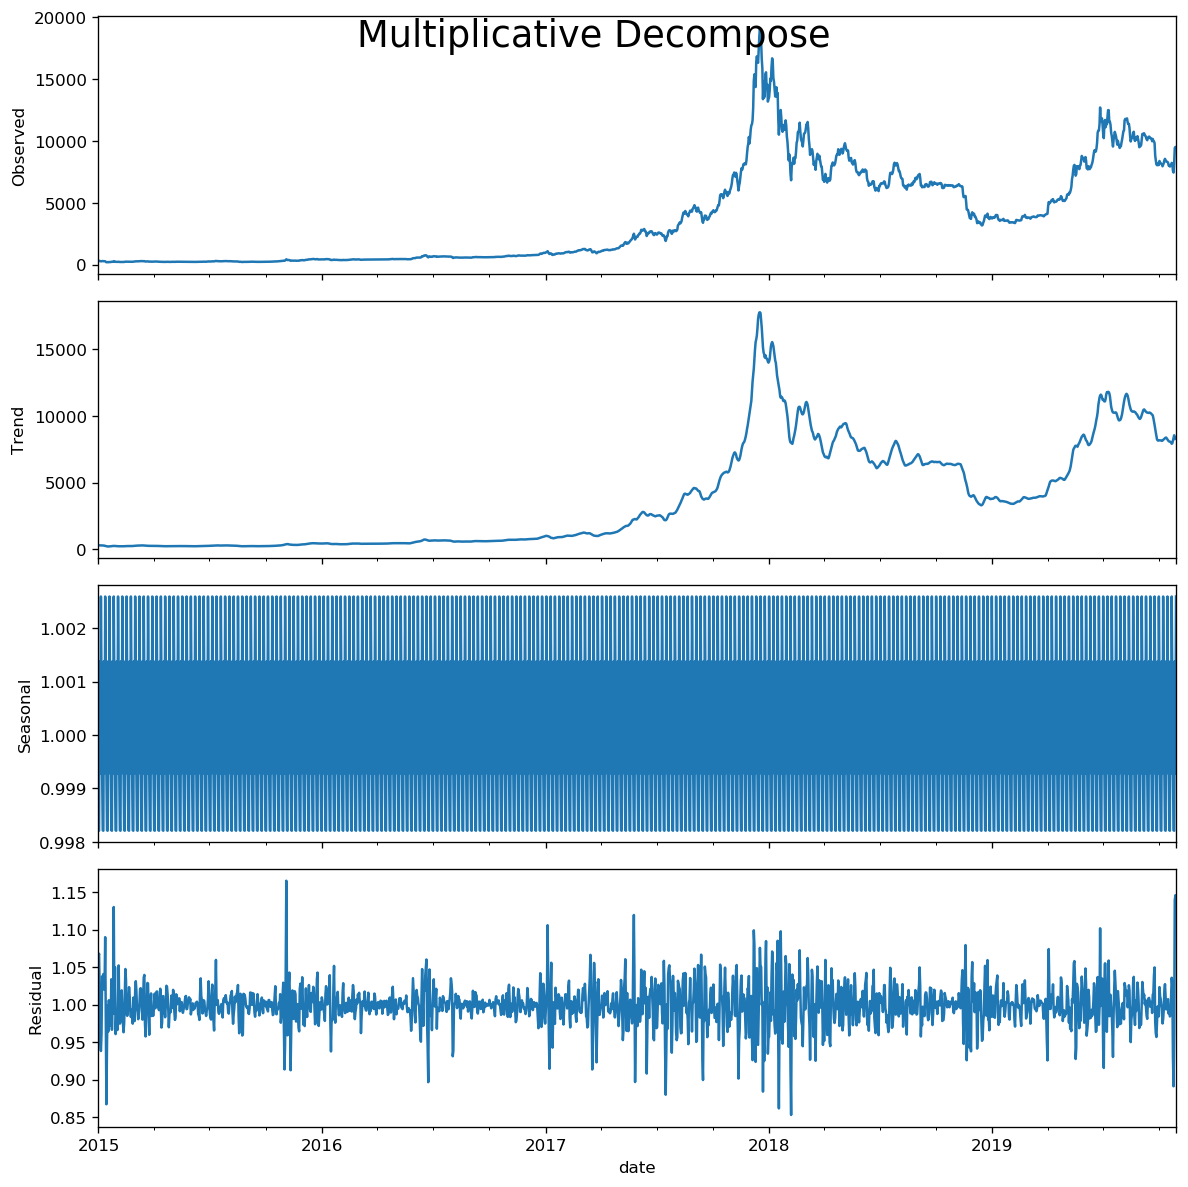

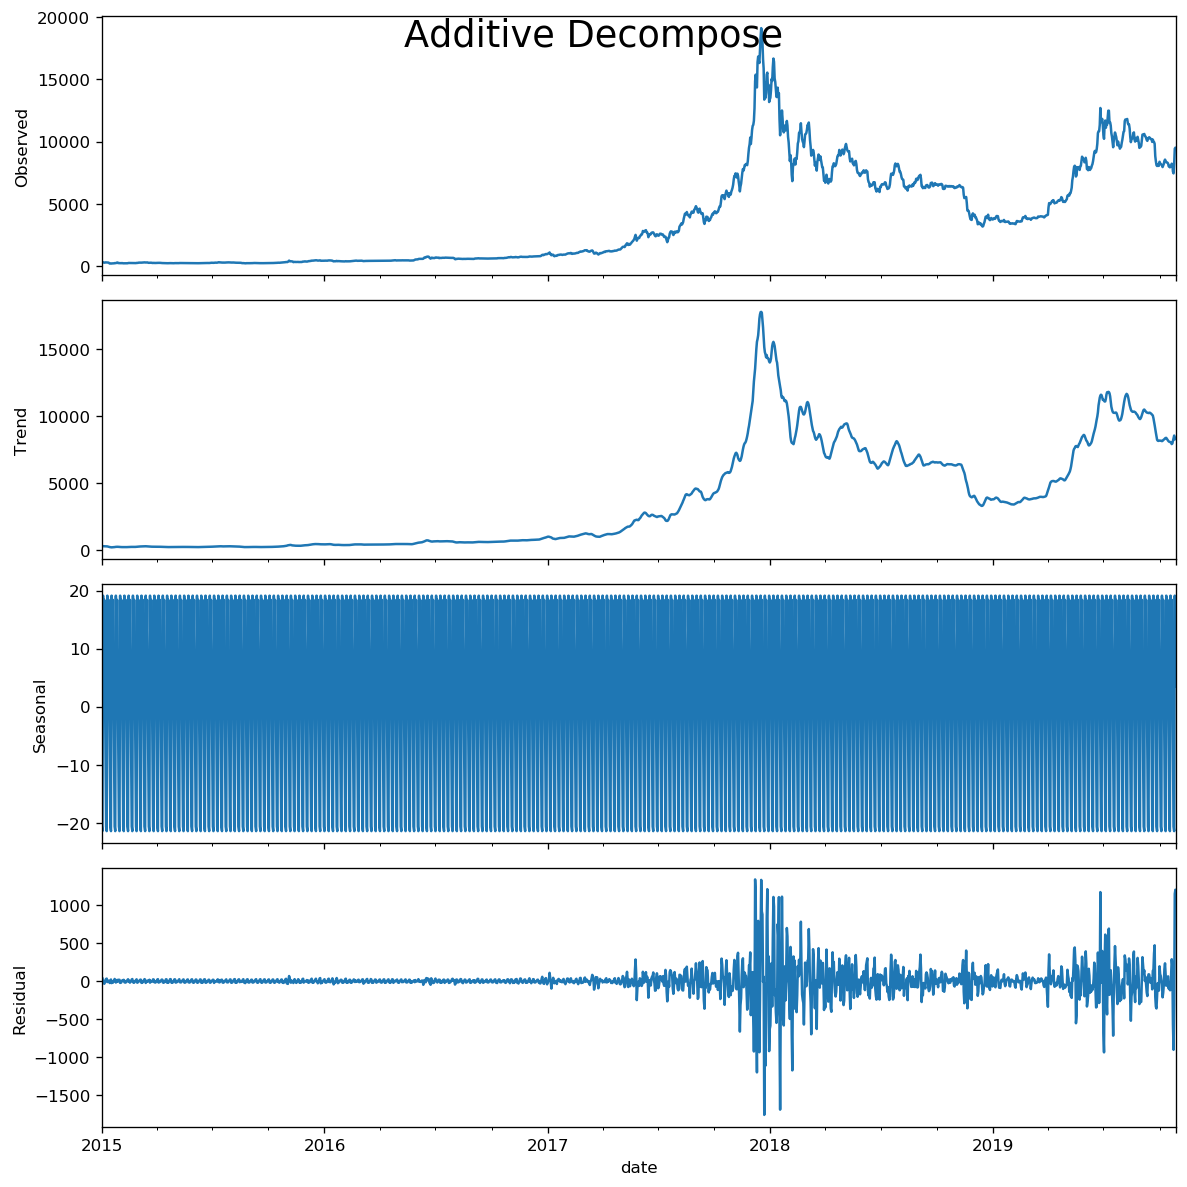

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

print(combined_df.index[:10])
# Multiplicative Decomposition 
result_mul = seasonal_decompose(combined_df['BTC'].dropna(), model='multiplicative', 
                                extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(combined_df['BTC'].dropna(), model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

## Make Process Stationary

In [20]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(combined_df['BTC'].dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(combined_df['BTC'].dropna(), regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.4726859206785998
p-value: 0.546977370713075
Critial Values:
   1%, -3.4341224629678426
Critial Values:
   5%, -2.863206331927479
Critial Values:
   10%, -2.5676571071932934

KPSS Statistic: 4.484289
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\statsmodels\tsa\stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning:

p-value is smaller than the indicated p-value



## Detrend

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the least squares fit')

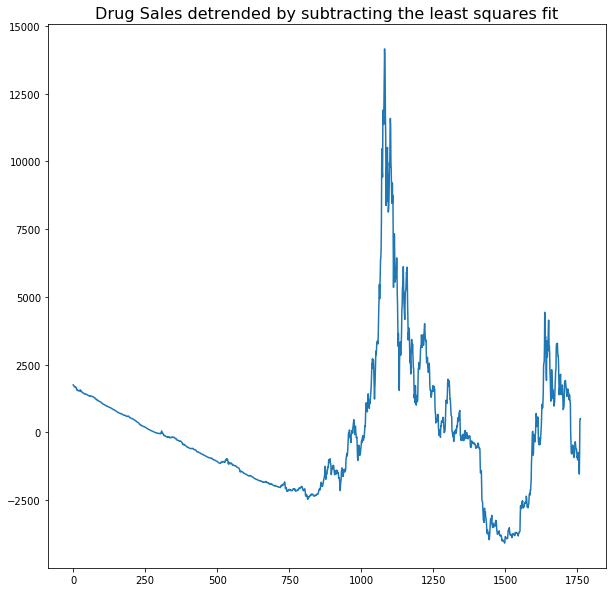

In [21]:
# Using scipy: Subtract the line of best fit
from scipy import signal
detrended = signal.detrend(combined_df['BTC'].dropna())
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the least squares fit', fontsize=16)

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the trend component')

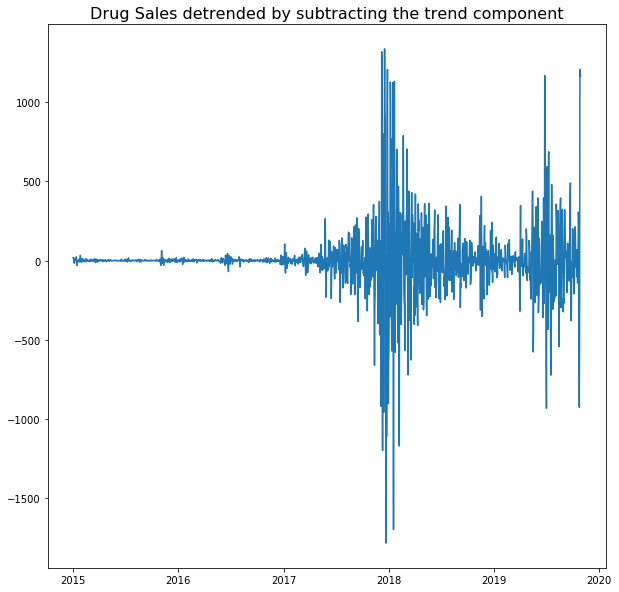

In [22]:
# Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(combined_df['BTC'].dropna(), model='multiplicative', extrapolate_trend='freq')
detrended = combined_df['BTC'].dropna() - result_mul.trend
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the trend component', fontsize=16)

## Deseasonalize

[]

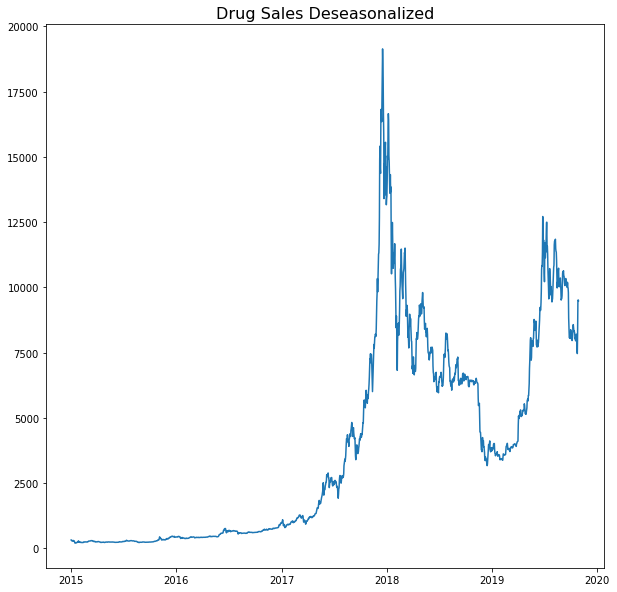

In [23]:
# Subtracting the Trend Component.

# Time Series Decomposition
result_mul = seasonal_decompose(combined_df['BTC'].dropna(), model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = combined_df['BTC'].dropna() / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Drug Sales Deseasonalized', fontsize=16)
plt.plot()

## Test for seasonality

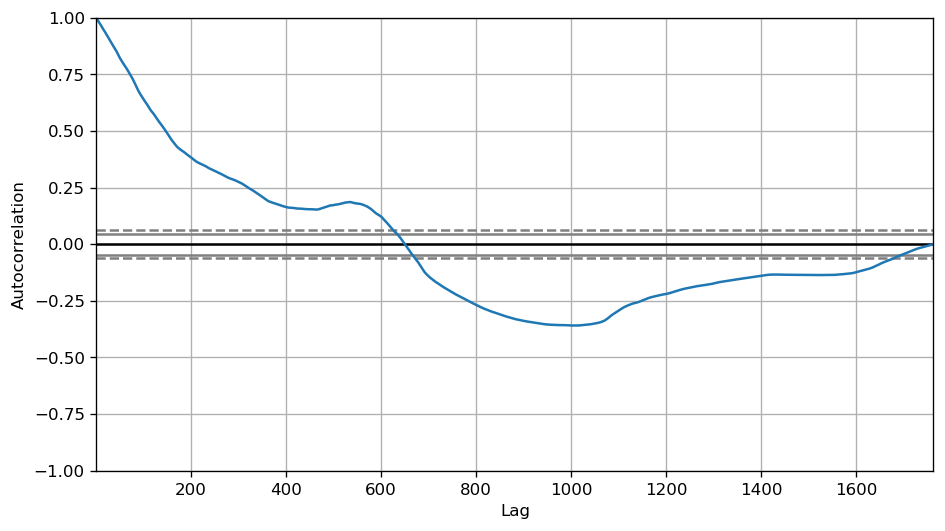

In [24]:
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(combined_df['BTC'].dropna())

# Forecasting

date
2015-01-01     317.354686
2015-01-02     316.004294
2015-01-03     299.043295
2015-01-04     277.941075
2015-01-05     272.033668
2015-01-06     275.208814
2015-01-07     294.282810
2015-01-08     289.922333
2015-01-09     293.942621
2015-01-10     283.027531
2015-01-11     269.317180
2015-01-12     274.749891
2015-01-13     233.976733
2015-01-14     197.161150
2015-01-15     207.698502
2015-01-16     209.533719
2015-01-17     200.173455
2015-01-18     211.208806
2015-01-19     210.793096
2015-01-20     214.778560
2015-01-21     216.731150
2015-01-22     235.760458
2015-01-23     230.194441
2015-01-24     242.736054
2015-01-25     248.175964
2015-01-26     281.830892
2015-01-27     246.055089
2015-01-28     258.963231
2015-01-29     233.072453
2015-01-30     230.816121
                 ...     
2019-09-29    8047.082113
2019-09-30    8059.472598
2019-10-01    8381.465831
2019-10-02    8257.932279
2019-10-03    8205.767245
2019-10-04    8148.270835
2019-10-05    8108.367385
2019-10

C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



2019-10-29     9543.071300
2019-10-30     9546.411944
2019-10-31     9535.815716
2019-11-01     9588.532968
2019-11-02     9590.772785
2019-11-03     9583.081701
2019-11-04     9547.105383
2019-11-05     9624.510159
2019-11-06     9628.698347
2019-11-07     9592.078207
2019-11-08     9598.213867
2019-11-09     9663.752240
2019-11-10     9651.529341
2019-11-11     9614.168485
2019-11-12     9648.854004
2019-11-13     9699.614627
2019-11-14     9668.955190
2019-11-15     9646.045348
2019-11-16     9699.064650
2019-11-17     9728.658898
2019-11-18     9686.653829
2019-11-19     9686.204057
2019-11-20     9746.164888
2019-11-21     9751.117615
2019-11-22     9708.621539
2019-11-23     9732.452189
2019-11-24     9787.440492
2019-11-25     9769.277817
2019-11-26     9737.405248
2019-11-27     9781.624427
                  ...     
2020-01-08    10160.877818
2020-01-09    10127.440143
2020-01-10    10125.266676
2020-01-11    10178.014174
2020-01-12    10186.632810
2020-01-13    10151.152779
2

C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



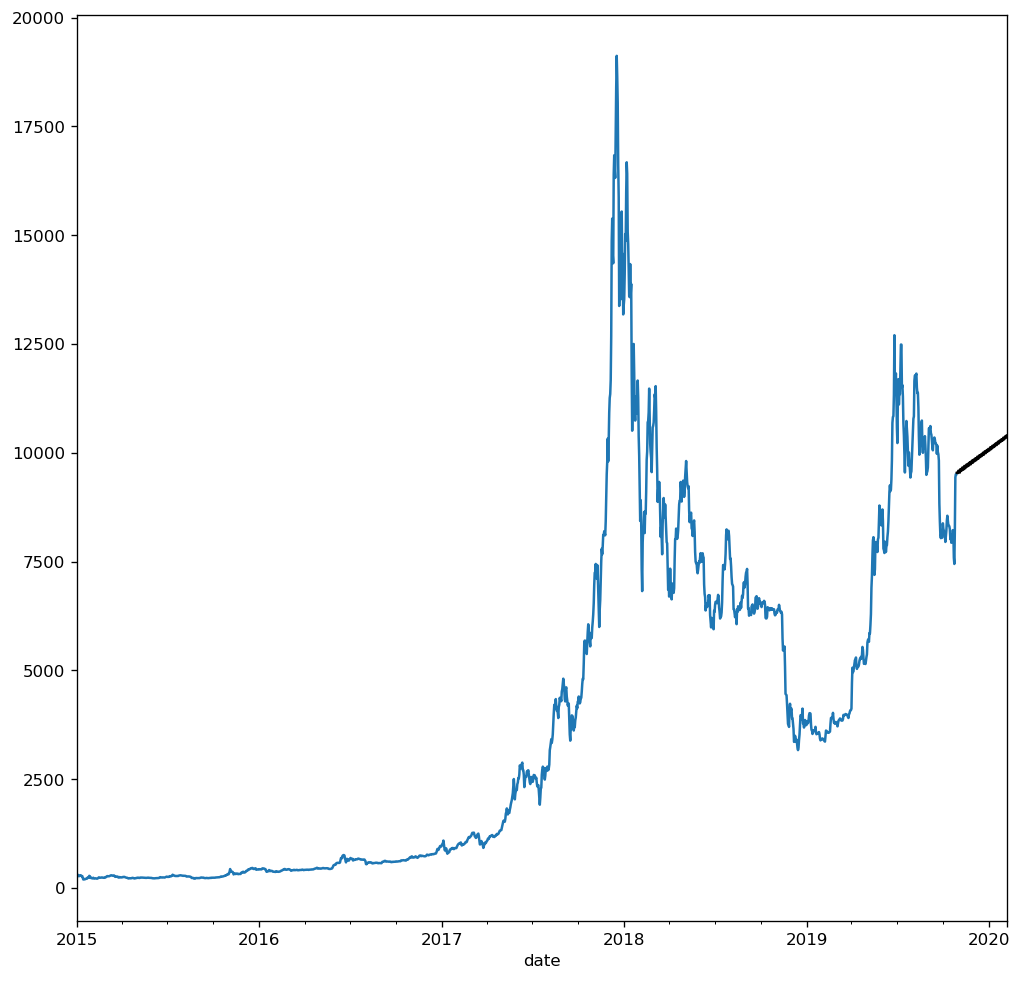

In [57]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from random import random
# contrived dataset
data = combined_df['BTC'].dropna()
print(data)
# fit model
model = ARIMA(data, order=(3, 2, 10))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data)+100, typ='levels')
print(yhat)
data.plot()
yhat.plot(style = '-', color = 'black')

In [59]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1141 entries, 2015-01-05 to 2019-10-28
Data columns (total 4 columns):
Gold      1141 non-null float64
Silver    1141 non-null float64
Yuan      1141 non-null float64
BTC       1141 non-null float64
dtypes: float64(4)
memory usage: 84.6 KB


C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



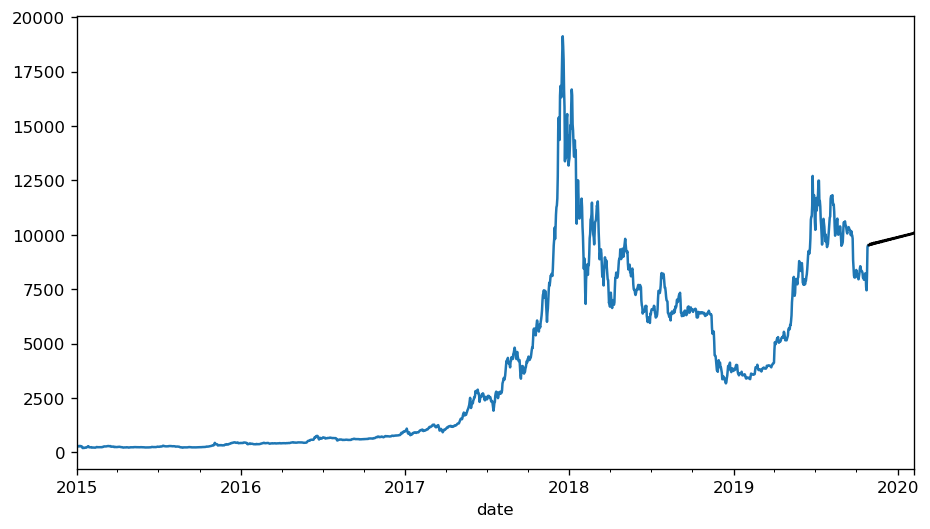

In [26]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# fit model
model = SARIMAX(data, order=(3, 2, 10), seasonal_order=(0,0,0,0))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data)+100)
data.plot()
yhat.plot(style = '-', color = 'black')

C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning:

Optimization failed to conv

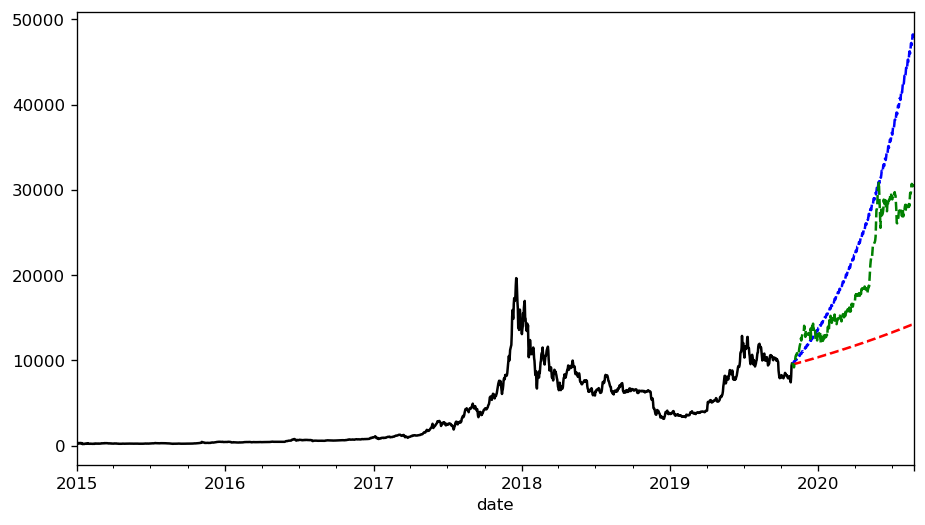

In [27]:
# Hold Winters Exponential Smoothing example
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from random import random
# fit model
model1 = ExponentialSmoothing(data, trend = 'add', seasonal = 'add',
                             seasonal_periods = 4,
                            damped = False)
model2 = ExponentialSmoothing(data, trend = 'add', seasonal = 'mul',
                             seasonal_periods = 4,
                            damped = False)
model3 = ExponentialSmoothing(data, trend = 'add', seasonal = 'add',
                             seasonal_periods = 24*30#,
                             #damped = True
                             )
model_fit1 = model1.fit(use_boxcox = True)
model_fit2 = model2.fit(use_boxcox = True)
model_fit3 = model3.fit(use_boxcox = True)

# make prediction
forecast_n = 300
yhat = model_fit1.predict(len(data), len(data)+100)
#print(yhat)

model_fit1.fittedvalues.plot(style = '-', color = 'black')
model_fit1.forecast(forecast_n).plot(style = '--', color = 'blue')
model_fit2.forecast(forecast_n).plot(style = '--', color = 'red')
model_fit3.forecast(forecast_n).plot(style = '--', color = 'green')
plt.show()

# Forecasting with further Information

## Test mit Pseudodaten

C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



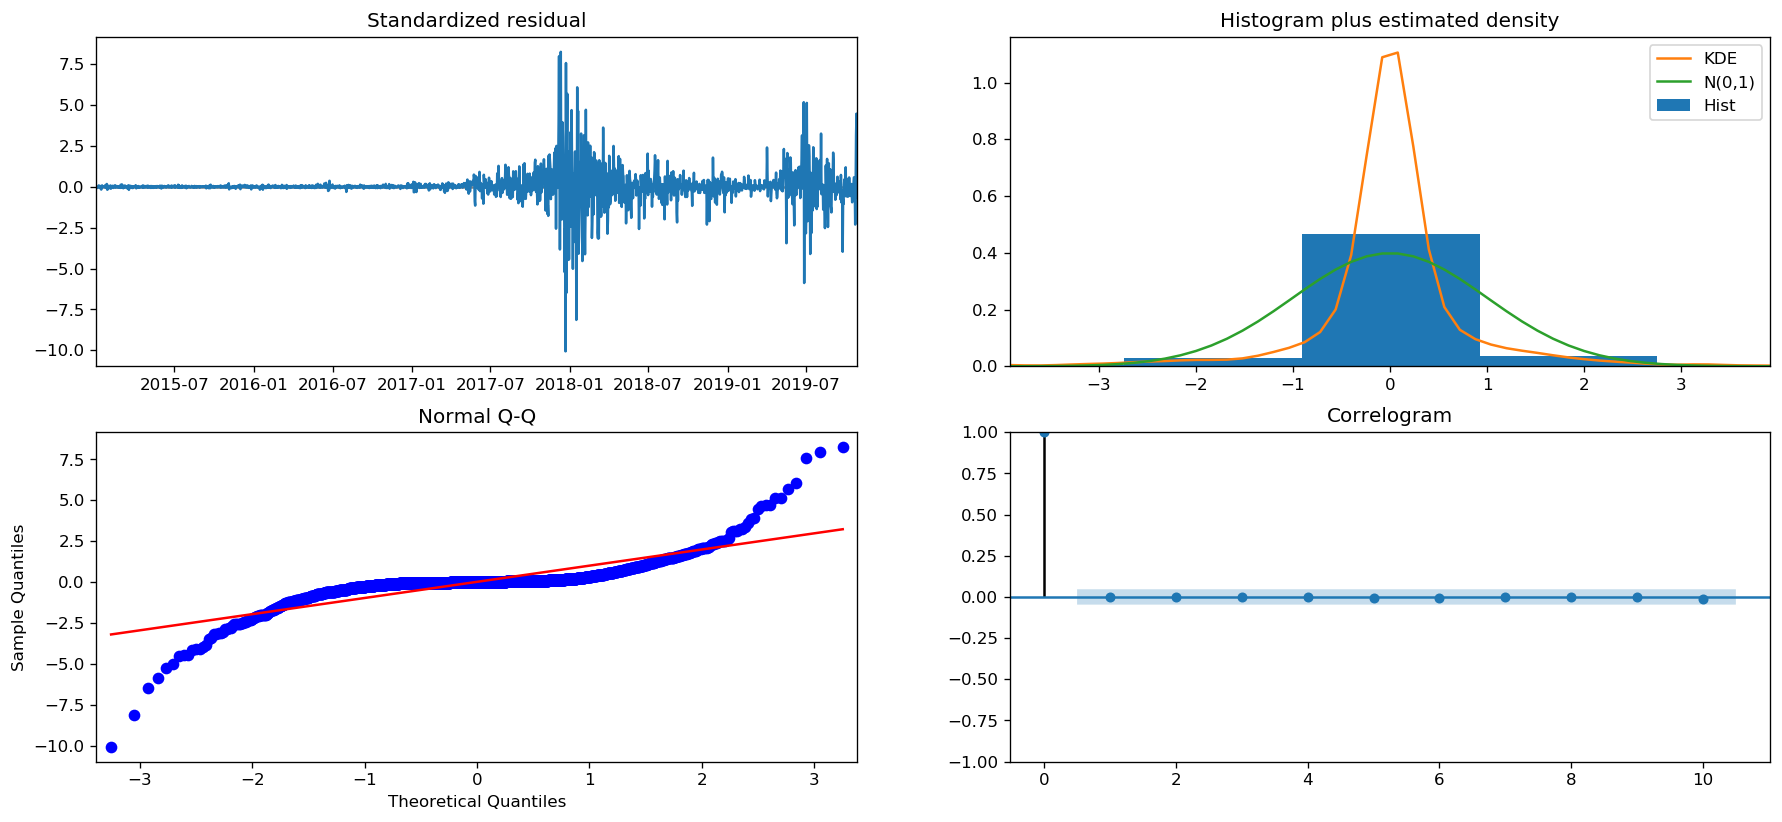

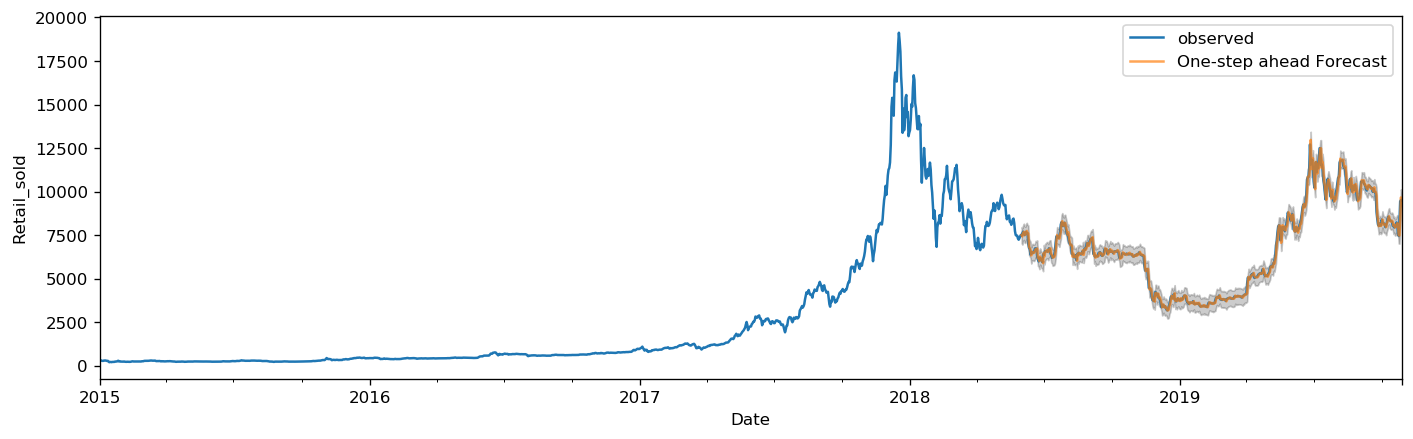

In [28]:
# SARIMAX example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset
data_ex = [x/10000 + random() for x in data]
#print(data_ex[10])
# fit model
model = SARIMAX(data, exog=data_ex, order=(5, 1, 10), seasonal_order=(0, 0, 0, 48*30))
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(18, 8))
plt.show()
# make prediction

pred = model_fit.get_prediction(start=pd.to_datetime('2018-06-01'), dynamic=False)

pred_ci = pred.conf_int()
ax = data.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()



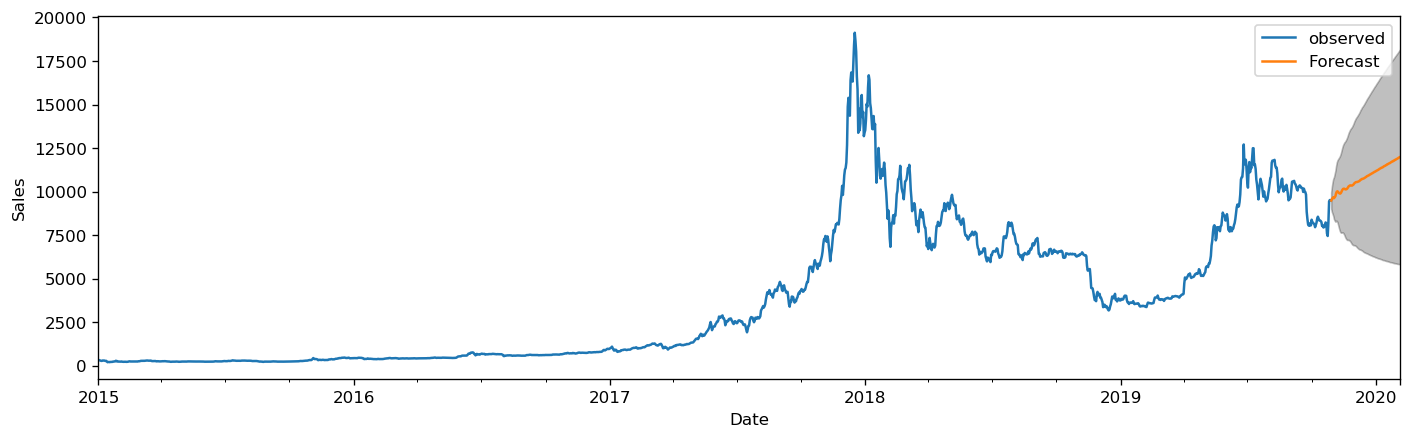

In [29]:
# make forecast
forecast_n = 100
exog2 = [[x + random()] for x in range(0,forecast_n)]
pred_uc = model_fit.get_forecast(steps=forecast_n,exog=exog2)
pred_ci = pred_uc.conf_int()
ax = data.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

## Sarimax mit Realdaten

In [30]:
gold_usd_price_kraken = get_quandl_data('LBMA/GOLD', cache = load_from_cache)
silver_usd_price_kraken = get_quandl_data('LBMA/SILVER', cache = load_from_cache)
yuan_usd_price_kraken = get_quandl_data('BUNDESBANK/BBEX3_D_CNY_USD_CA_AC_000', cache = load_from_cache)


#print('\n Gold: \n',gold_usd_price_kraken.tail(),'\n', gold_usd_price_kraken.index)
#print('\n Silver: \n',silver_usd_price_kraken.tail(),'\n', silver_usd_price_kraken.index)
#print('\n Yuan Renminbi: \n',yuan_usd_price_kraken.tail(),'\n', yuan_usd_price_kraken.index)

Loaded LBMA/GOLD from cache
Loaded LBMA/SILVER from cache
Loaded BUNDESBANK/BBEX3_D_CNY_USD_CA_AC_000 from cache


In [31]:
data_gold = pd.DataFrame(data = {#'Date_col' : gold_usd_price_kraken.loc['1994-04-01':'2019-11-01'].index,
                                 'Gold' : gold_usd_price_kraken.loc['2015-01-01':'2019-11-01']['USD (AM)']}
                        )
data_silver = pd.DataFrame(data = {#'Date_col': silver_usd_price_kraken.loc['1994-04-01':'2019-11-01'].index,
                                   'Silver': silver_usd_price_kraken.loc['2015-01-01':'2019-11-01']['USD']}
                          )
data_yuan = pd.DataFrame(data = {#'Date_col': yuan_usd_price_kraken.loc['1994-04-01':'2019-11-01'].index,
                                 'Yuan': yuan_usd_price_kraken.loc['2015-01-01':'2019-11-01']['Value']}
                        )
data_ex = data_gold.join(data_silver, how = 'outer', on = 'Date').join(data_yuan, how = 'outer', on = 'Date',sort = True)

data_full = data_ex.join(data, how = 'inner', on = 'Date').dropna()

#data_full = data_full.set_index('Date')
print(data_full)

               Gold  Silver    Yuan           BTC
Date                                             
2015-01-05  1192.00  15.880  6.1248    272.033668
2015-01-06  1211.00  16.290  6.1256    275.208814
2015-01-07  1213.75  16.330  6.1269    294.282810
2015-01-08  1206.50  16.370  6.1302    289.922333
2015-01-09  1211.25  16.240  6.1296    293.942621
2015-01-12  1222.00  16.520  6.1233    274.749891
2015-01-13  1239.00  17.000  6.1195    233.976733
2015-01-14  1228.75  16.640  6.1205    197.161150
2015-01-15  1235.25  17.120  6.1193    207.698502
2015-01-16  1258.25  16.920  6.1188    209.533719
2015-01-19  1275.50  17.650  6.1230    210.793096
2015-01-20  1292.25  17.800  6.1226    214.778560
2015-01-21  1298.00  18.220  6.1268    216.731150
2015-01-22  1287.00  18.080  6.1247    235.760458
2015-01-23  1293.50  18.230  6.1342    230.194441
2015-01-26  1282.75  17.830  6.1384    281.830892
2015-01-27  1279.00  17.870  6.1364    246.055089
2015-01-28  1287.00  18.010  6.1282    258.963231


C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



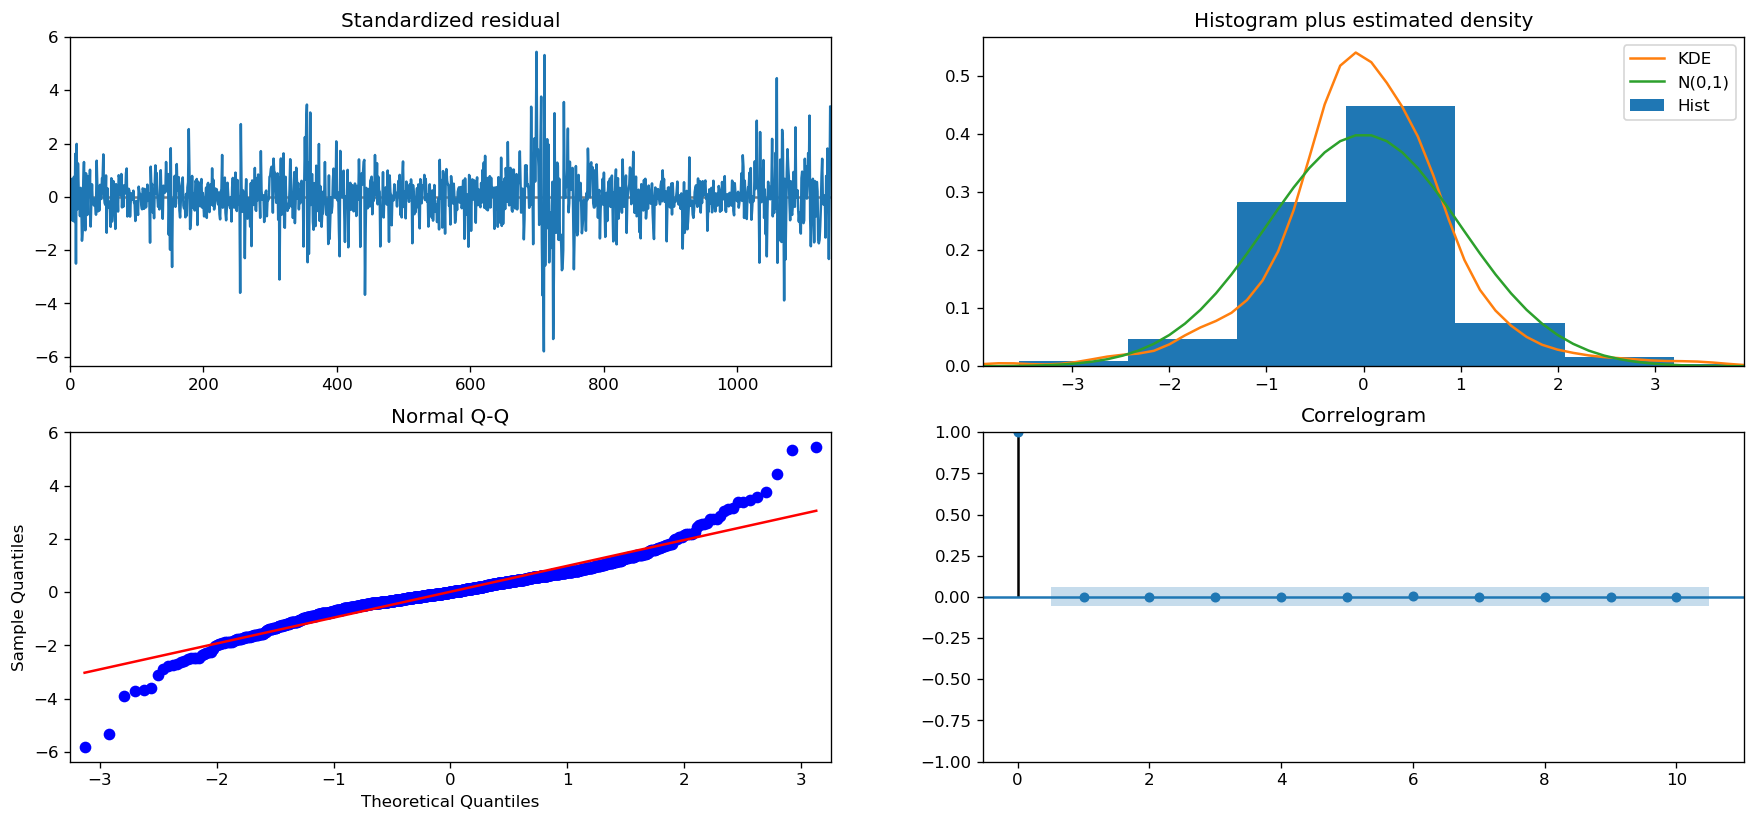

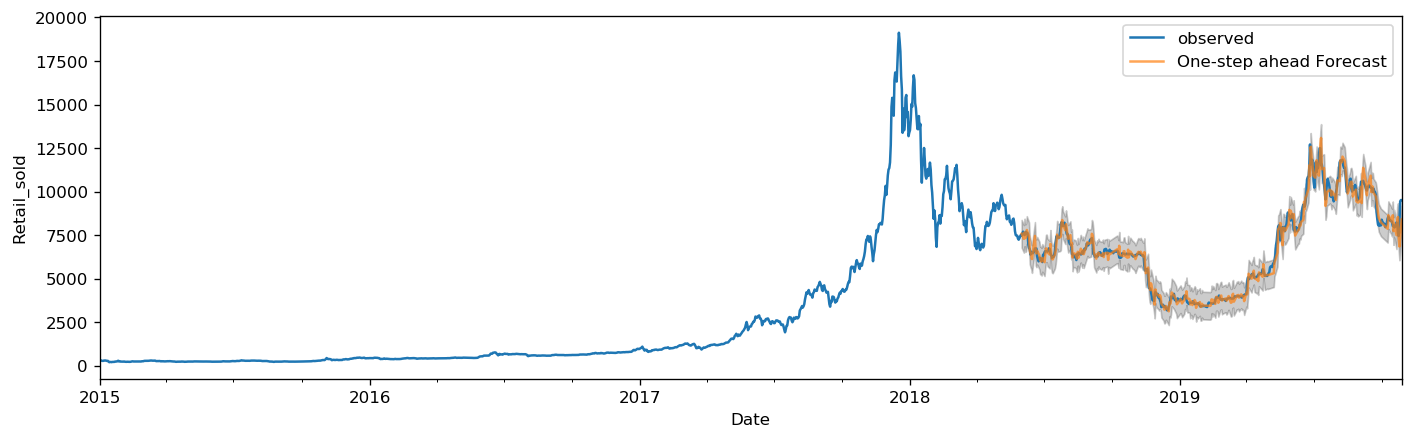

In [32]:
# fit model
model = SARIMAX(data_full['BTC'], exog=data_full[['Gold', 'Silver', 'Yuan']], 
                order=(3, 0, 10), seasonal_order=(0, 0, 0, 48*30))
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(18, 8))
plt.show()
# make prediction

pred = model_fit.get_prediction(start=pd.to_datetime('2018-06-01'), dynamic=False)

pred_ci = pred.conf_int()
ax = data.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()



C:\Users\mnelz\AppData\Local\Continuum\anaconda3\envs\Keras-GPU\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



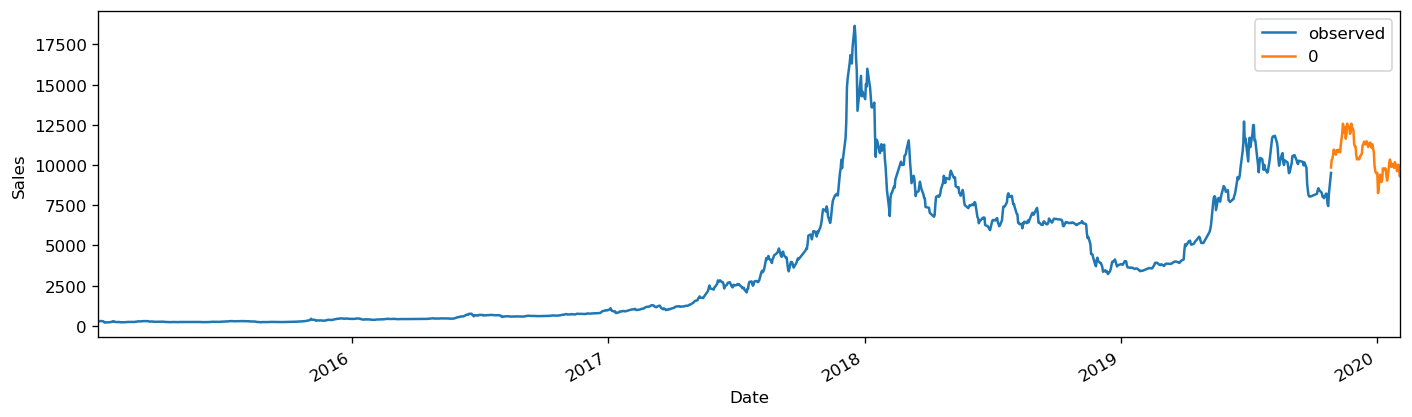

In [33]:
# make forecast
forecast_n = 100
exog = pd.DataFrame([[x + random(),x + random(),x + random()] for x in range(0,forecast_n)])

exog = data_full.iloc[-forecast_n:][['Gold','Silver','Yuan']]
exog['Date'] = range(len(data_full),len(data_full)+ forecast_n)
exog['Date'] = pd.date_range(data_full.index[-1],periods =  forecast_n)

exog = exog.set_index('Date')
#print(exog)
#exog.index.freq = None

pred_uc = model_fit.get_forecast(steps=forecast_n, exog=exog)
pred_ci = pred_uc.conf_int()
ax = data_full['BTC'].plot(label='observed', figsize=(14, 4))

#print(data_full.index.freq,'\n',ax.freq,'\n\n')
#print(pred_uc.predicted_mean)
pred_line = pd.DataFrame(pred_uc.predicted_mean)
pred_line['Date'] = pd.date_range(data_full.index[-1],periods =  forecast_n)
pred_line = pred_line.set_index('Date')
#print(pred_line)

pred_line.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

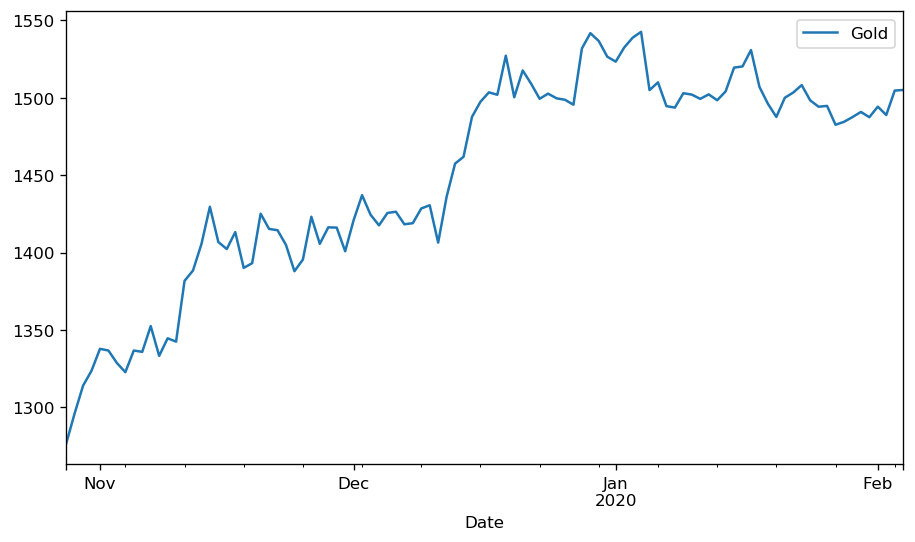

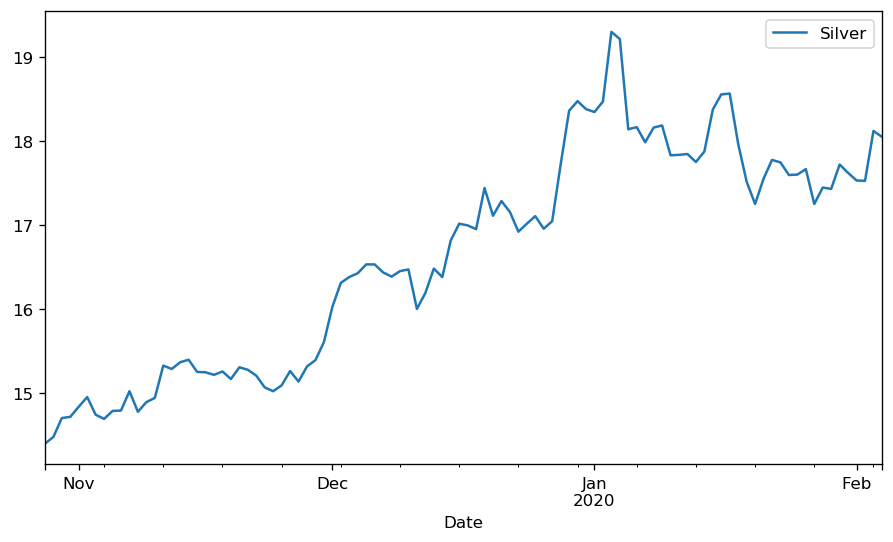

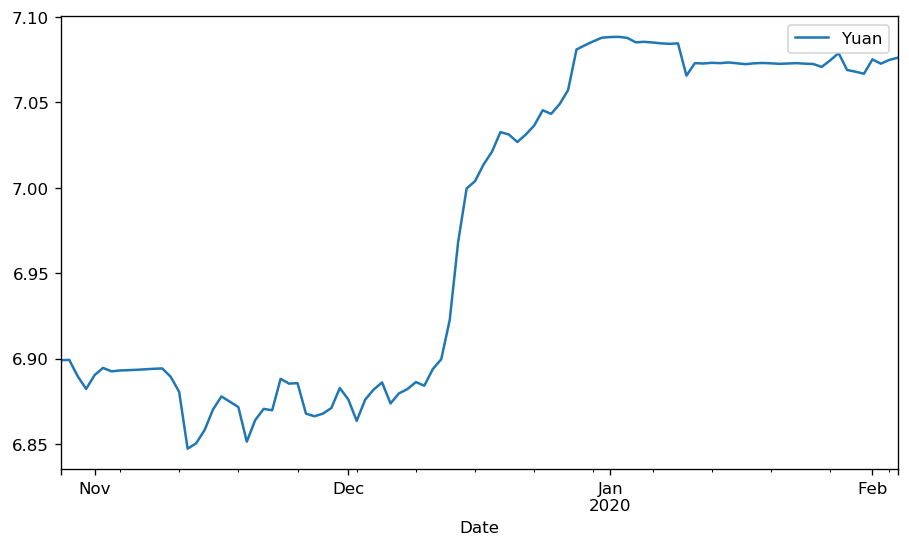

In [53]:
exog[['Gold']].plot()
exog[['Silver']].plot()
exog[['Yuan']].plot()

In [42]:
agent_file = r"C:\Users\mnelz\Documents\Python Scripts\Cryptocurrency\Reinforcement_Learning_for_Stock_Prediction-master\agent\agent.py"
functions_file = r"C:\Users\mnelz\Documents\Python Scripts\Cryptocurrency\Reinforcement_Learning_for_Stock_Prediction-master\functions.py"
exec(open(agent_file).read())
exec(open(functions_file).read())


Episode 0/2
Buy: $3980.92
Sell: $4063.44 | Profit: $82.51
Buy: $5239.45
Sell: $5214.11 | Profit: -$25.34
Buy: $5221.19
Sell: $5268.08 | Profit: $46.90
Buy: $5152.54
Buy: $5148.02
Buy: $5849.29
Sell: $6045.30 | Profit: $892.76
Buy: $6295.32
Buy: $7646.12
Sell: $7990.38 | Profit: $2842.36
Buy: $7983.74
Learn!
Sell: $7196.20 | Profit: $1346.91
Learn!
Buy: $7902.43
Learn!
Sell: $7950.56 | Profit: $1655.24
Learn!
Buy: $7832.24
Learn!
Buy: $7721.84
Learn!
Learn!
Sell: $8689.06 | Profit: $1042.95
Learn!
Sell: $8624.94 | Profit: $641.21
Learn!
Buy: $8559.94
Learn!
Sell: $8333.64 | Profit: $431.21
Learn!
Sell: $8434.40 | Profit: $602.16
Learn!
Learn!
Sell: $7766.79 | Profit: $44.95
Learn!
Sell: $7698.83 | Profit: -$861.10
Learn!
Learn!
Buy: $7876.96
Learn!
Buy: $8066.25
Learn!
Sell: $8188.03 | Profit: $311.07
Learn!
Buy: $8426.45
Learn!
Buy: $9254.52
Learn!
Learn!
Sell: $9154.57 | Profit: $1088.31
Learn!
Buy: $9392.79
Learn!
Sell: $9828.26 | Profit: $1401.82
Learn!
Learn!
Learn!
Learn!
Learn!
S

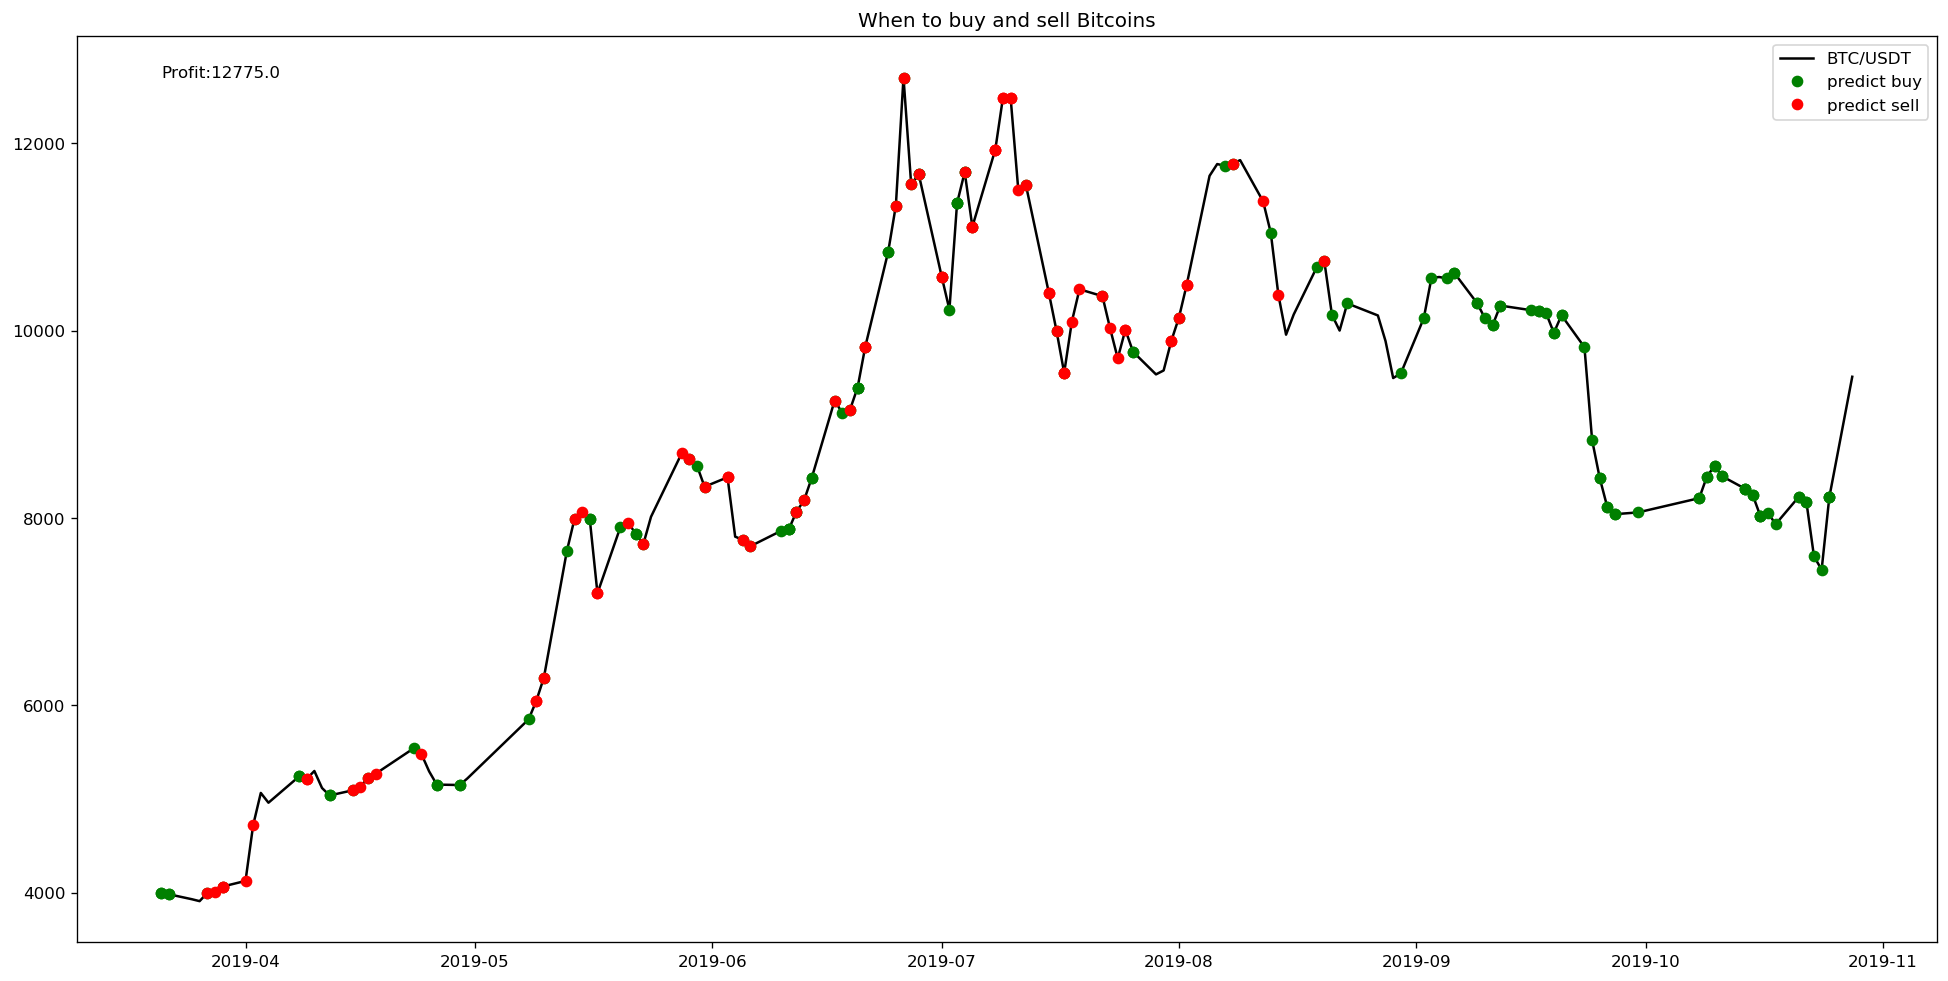

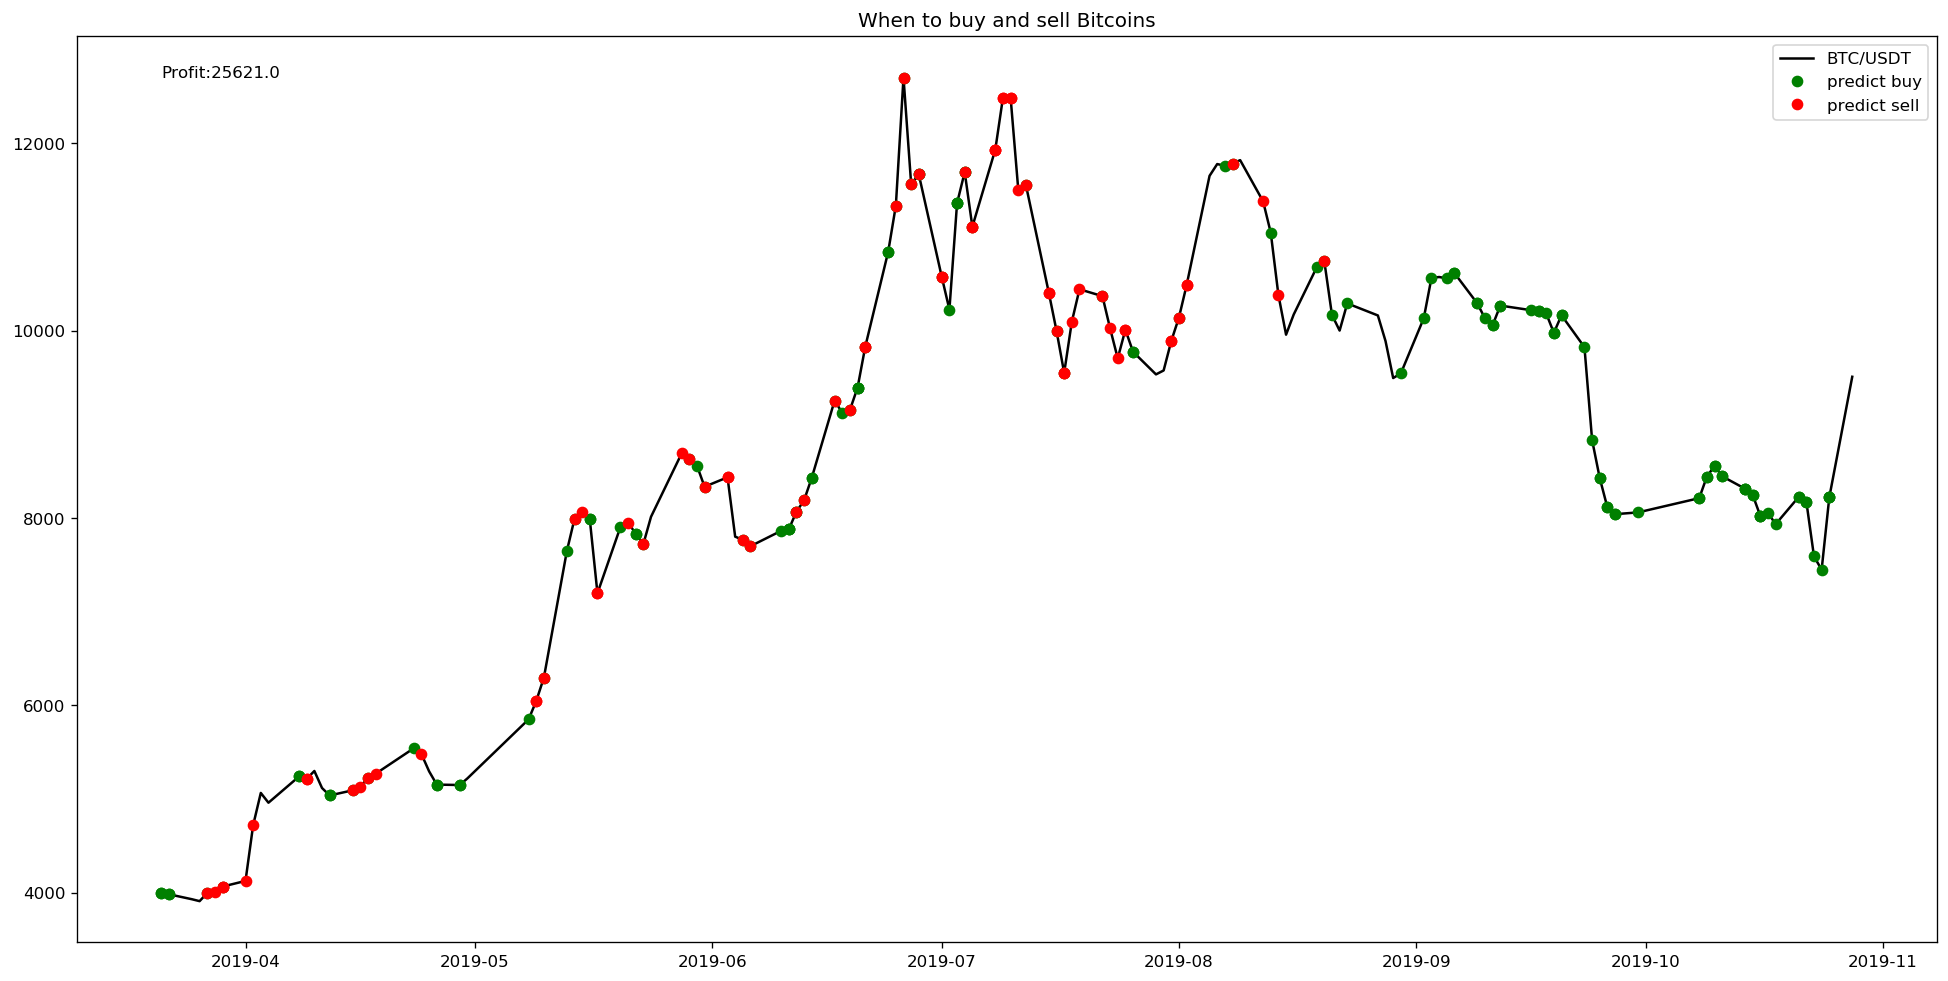

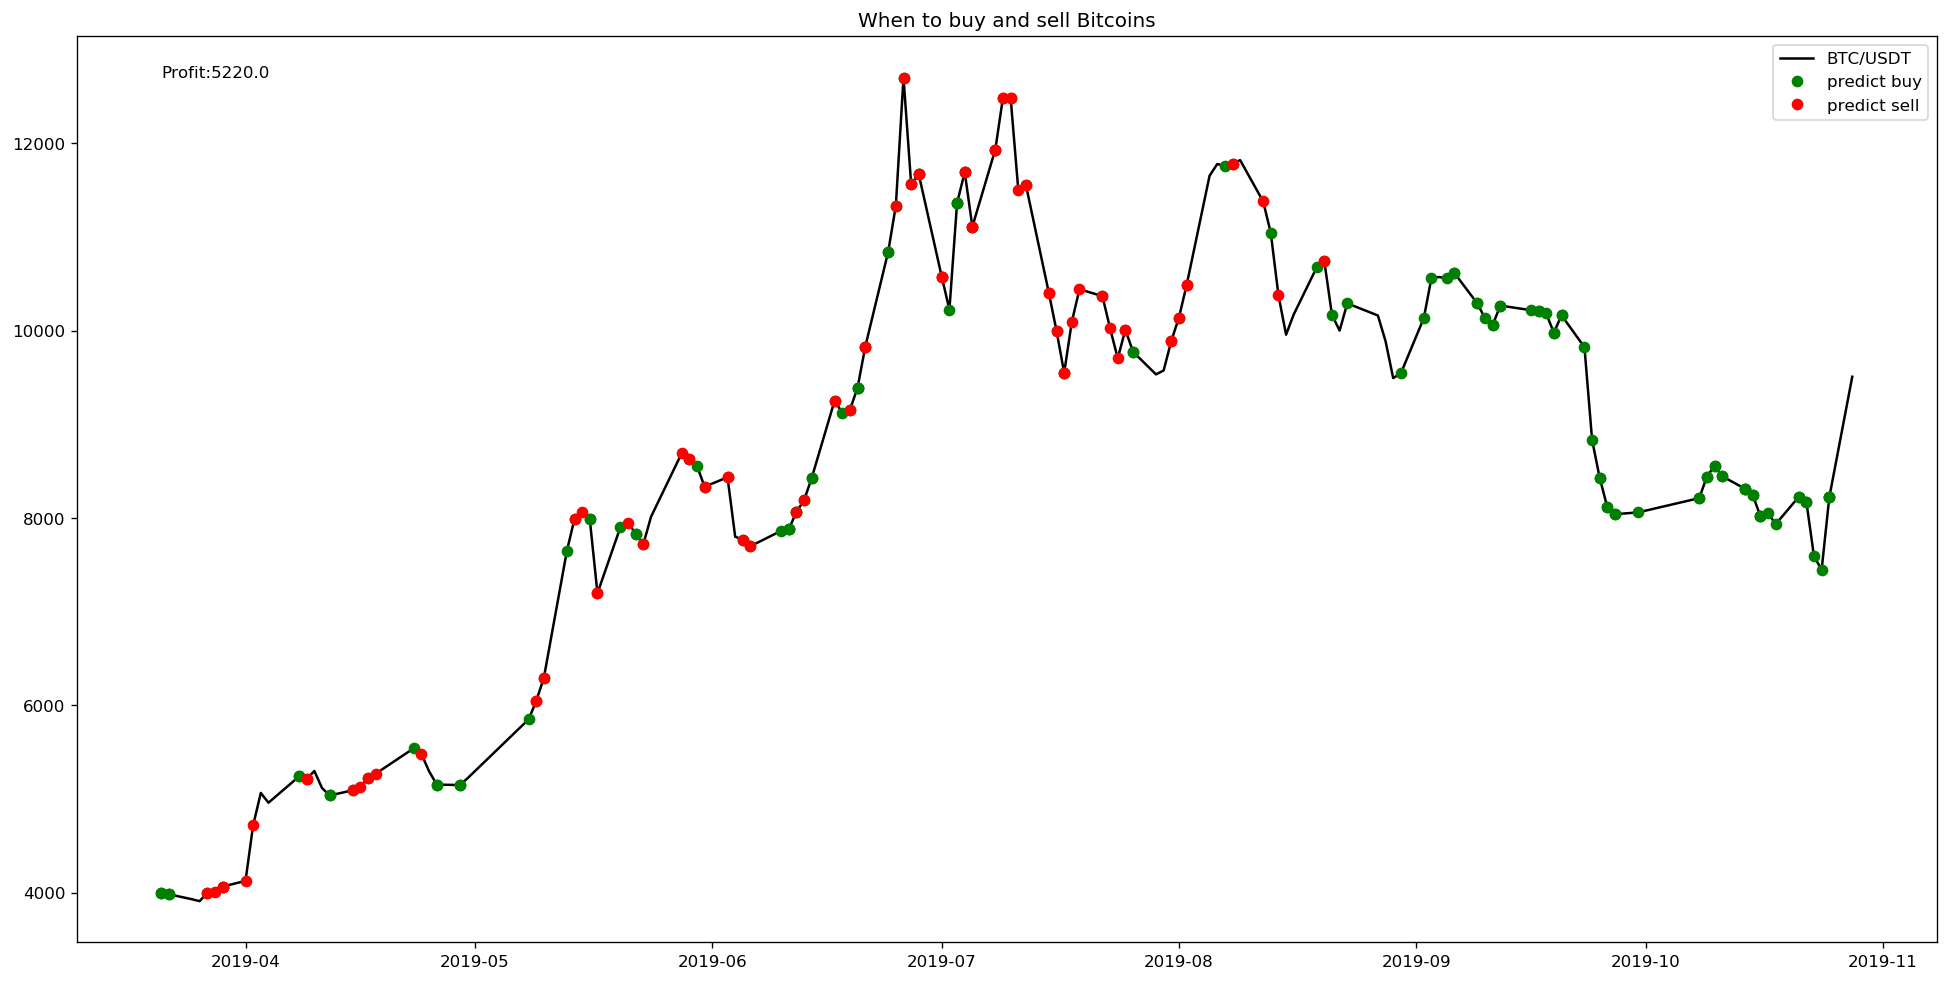

In [50]:
         
#from agent.agent import Agent
#from functions import *

import sys
#
#if len(sys.argv) != 4:
#    print("Usage: python train.py [stock] [window] [episodes]")
#    exit()
#
window_size = 10
episode_count = 2#0
#
agent = Agent(window_size)
data = data_full['BTC'][1000:]
#print(data)
l = len(data) - 1
batch_size = 32
#getState()
budget_start = 20000
budget_start = np.max(data) * len(data)

states_sell = []
states_buy = []

for e in range(episode_count + 1):
    
    budget = budget_start
    print("Episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)

    total_profit = 0
    agent.inventory = []
    
    for t in range(l):
        #print(t)
        action = agent.act(state)

        # sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0
        
        if t != 0 and t > 50:
            mean_price = np.mean(data[(t - 50):t])  
        elif t != 0:
            mean_price = np.mean(data[0:t])  
        else:
            mean_price = data[0]
        
        if action == 1 and np.sum(agent.inventory) + data[t] <= budget: # buy
            agent.inventory.append(data[t])
            budget -= data[t]
            states_buy.append(t)
            print("Buy: " + formatPrice(data[t]))

        elif action == 2 and len(agent.inventory) > 0 and data[t] > mean_price: # sell
            bought_price = agent.inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            budget += data[t] 
            states_sell.append(t)
            print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
        
            #agent.inventory.append(data[t])
            #print("Sell: " + formatPrice(data[t]) + " | Profit: " + str(round(np.sum(agent.inventory),2)))
        
        # Verluste stärker bestrafen(penalty_factor > 1) bzw. geringer zu bestrafen (1 > penalty_factor > 0):
        penalty_factor = 0.25
        if reward < 0:
            reward = reward * penalty_factor
            
        done = True if t == l - 1 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("Final Budget: " + formatPrice(budget))
            print("--------------------------------")

        if len(agent.memory) > batch_size:
            print('Learn!')
            agent.expReplay(batch_size)

    if e % 1 == 0:
        try: 
            os.mkdir('models')
        except:
            pass
        agent.model.save("models/model_ep" + str(e))
    
    try: 
        os.mkdir('models/plots')
    except:
        pass
    
    figure = "models/plots/model_ep{}.png".format(str(e))
    plt.figure(figsize = (20, 10))
    plt.plot(data, label = 'BTC/USDT', c = 'black')
    plt.text(np.min(data.index),np.max(data),'Profit:{}'.format(round(total_profit,0)))
    plt.title('When to buy and sell Bitcoins')
    plt.plot(data, 'o', label = 'predict buy', markevery = states_buy, c = 'g')
    plt.plot(data, 'o', label = 'predict sell', markevery = states_sell, c = 'r')
    plt.legend()
    plt.savefig(figure) 


141

In [ ]:
import keras
from keras.models import load_model

#from agent.agent import Agent
#from functions import *
import sys

#stock_name, 
model_name = 'model_ep0'
model = load_model("models/" + model_name)
window_size = model.layers[0].input.shape.as_list()[1]

agent = Agent(window_size, True, model_name)
data = data
l = len(data) - 1
batch_size = 32

budget_start = 20000

state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []

states_sell = []
states_buy = []

for t in range(l):
    action = agent.act(state)

    # sit
    next_state = getState(data, t + 1, window_size + 1)
    reward = 0
    
    mean_price = np.mean(data[0:t]) if t != 0 else data[0]
        
    if action == 1 and np.sum(agent.inventory) + data[t] <= budget: # buy
        agent.inventory.append(data[t])
        budget -= data[t]
        states_buy.append(t)
        print("Buy: " + formatPrice(data[t]))

    elif action == 2 and len(agent.inventory) > 0 and data[t] > mean_price: # sell
        bought_price = agent.inventory.pop(0)
        reward = max(data[t] - bought_price, 0)
        total_profit += data[t] - bought_price
        budget += data[t] 
        states_sell.append(t)
        print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
        
    done = True if t == l - 1 else False
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("--------------------------------")
        print(" Total Profit: " + formatPrice(total_profit))
        print("--------------------------------")
        
#figure = "models/plots/model_ep{}.png".format(str(e))
plt.figure(figsize = (20, 10))
plt.plot(data, label = 'BTC/USDT', c = 'black')
plt.text(np.min(data.index),np.max(data),'Profit:{}'.format(round(total_profit,0)))
plt.title('When to buy and sell Bitcoins')
plt.plot(data, 'o', label = 'predict buy', markevery = states_buy, c = 'g')
plt.plot(data, 'o', label = 'predict sell', markevery = states_sell, c = 'r')
plt.legend()
#plt.savefig(figure) 

In [ ]:
a = deque(maxlen =10)

for i in range(20):
    a.append(i)

a